In [1]:
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import missingno as msno
import numpy as np
import re
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn import metrics
from sklearn.utils import resample

from xgboost import XGBRegressor, XGBClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Caricamento e breve esplorazione iniziale

In [2]:
df = pd.read_csv('https://gitlab.com/261145/attivita-bda/-/raw/main/Attivit%C3%A0%205/Dataset1_Risposte_Questionari.txt',  delimiter='\t')

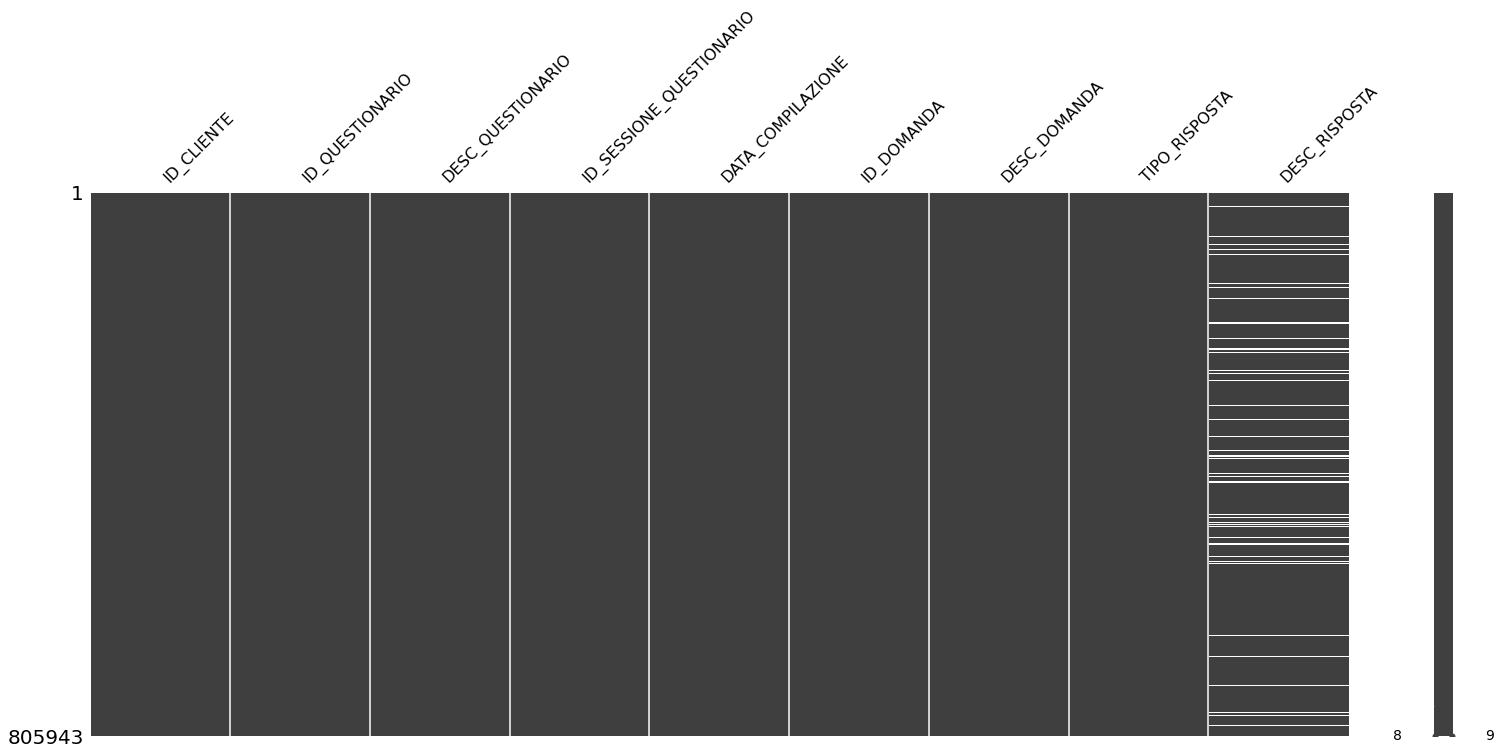

In [3]:
# guardo come sono distribuiti i valor nulli, noto che sono tutti nelle risposte aperte
msno.matrix(df)

In [4]:
# tutti i nan sono nella colonna delle risposte
df.isna().sum()

ID_CLIENTE                      0
ID_QUESTIONARIO                 0
DESC_QUESTIONARIO               0
ID_SESSIONE_QUESTIONARIO        0
DATA_COMPILAZIONE               0
ID_DOMANDA                      0
DESC_DOMANDA                    0
TIPO_RISPOSTA                   0
DESC_RISPOSTA               69391
dtype: int64

In [5]:
# quasi tutti i nan sono tra le risposte aperte
df[df.isna()['DESC_RISPOSTA']]['TIPO_RISPOSTA'].value_counts()

inputtextarea    69390
inputdate            1
Name: TIPO_RISPOSTA, dtype: int64

In [6]:
# tutti i tipi di risposte presenti
df['TIPO_RISPOSTA'].value_counts()

inputradio          632676
inputtextarea       119157
inputmulticheckb     53353
inputmatrix            722
inputdate               35
Name: TIPO_RISPOSTA, dtype: int64

In [7]:
# ci sono 23 tipi di questionari diversi
df['ID_QUESTIONARIO'].nunique()

23

In [8]:
df_questionari = df.copy()

In [9]:
df_questionari

ID_CLIENTE  ID_QUESTIONARIO  ...  TIPO_RISPOSTA               DESC_RISPOSTA
0          6149323               17  ...     inputradio  in-filiale-Cr-dit-agricole
1          6149323               17  ...     inputradio                  Abbastanza
2          6149323               17  ...     inputradio                 soddisfacen
3          6149323               17  ...     inputradio                          v8
4          6149323               17  ...     inputradio                          no
...            ...              ...  ...            ...                         ...
805938    24303175               82  ...     inputradio                          si
805939    24303175               82  ...     inputradio                          si
805940    24303175               82  ...     inputradio                          si
805941    24303175               82  ...     inputradio                          si
805942    24303175               82  ...  inputtextarea                         NaN

[805943 rows x 9 columns]

# Punteggi risposte
In queste celle si va ad effettuare una conversione di tutte le risposte chiuse nei loro punteggi. Per ogni tipo di risposta chiusa (radio, multicheck, ...), si va a creare un dizionario che ha come indice l'id del questionario e ognuna delle domande che ne fanno parte con tutte le relative risposte. In questo modo è stato possibile capire quali risposte sono utili per l'analisi e quali rimuovere.

In [10]:
# questa funzione serve per andare ad assegnare un punteggio a tutte le risposte
# chiuse per attribuire uno score di gradimento. Si utilizzano le espressioni
# regolari (a costo della minore manutenibilità del codice) perché così si riesce
# ad avere una maggiore flessibilità per gli errori di battitura nelle risposte

def evaluate_closed_answers(answers):
    # answers è una lista di tutte le risposte possibili per ogni domanda dei questionari

    # se sono nel caso in cui valuto tutte le risposte in formato 'v' poi voto
    # vado a mettere valori positivi per le valutazioni dal 5 in su, negative le altre
    if all([re.compile(r'v\d{1,2}').match(answer) for answer in answers]):
        return {answer:int(evaluation)-5 for answer, evaluation in zip(answers, re.compile(r'\d{1,2}').findall(' '.join(answers)))}

    # nel caso di risposte di tipo "poco, molto, abbastanza, per niente"
    if all(re.compile(r'(?i)(?:poco|molto|abbastanz.{0,2}|per.*nient.{0,1})').match(answer) for answer in answers):
        answer_4 = dict()
        for answer in answers:
            if (re.compile(r'(?i)per.*nient.{1}').match(answer)):
                answer_4[answer] = -2
            elif (re.compile(r'(?i)poco').match(answer)):
                answer_4[answer] = -1
            elif (re.compile(r'(?i)abbastanz.{1,2}').match(answer)):
                answer_4[answer] = 1
            elif (re.compile(r'(?i)molto').match(answer)):
                answer_4[answer] = 2
        return answer_4

    # nel caso di risposte sì/no
    if all(re.compile(r'(?i)(?:\bno{0,1}\b|\bs[iì]{1}\b)').match(answer) for answer in answers):
        answer_si_no = dict()
        for answer in answers:
            asnwer = answer.replace('ì', 'i') # rimuovo tutti gli accenti dal "sì"
            if (re.compile(r'(?i)(?:si|s.{0,1})').match(answer)):
                answer_si_no[answer] = 1
            elif (re.compile(r'(?i)(?:no|n.{0,1})').match(answer)):
                answer_si_no[answer] = -1

        return answer_si_no

    # qui considero le risposte del tipo "eccessivo", "non adeguato", "eccellente", ...
    if all(re.compile(r'(?i)(?:\beccessiv.{0,1}\b|\bnonadeguat.{0,1}\b|\bsoddisfacen.{0,1}.{0,1}\b|\beccellente\b|\bdifficoltosa\b)').match(answer) for answer in answers):
        answer_mult = dict()
        for answer in answers:
            if (re.compile(r'(?i)eccessiv.{0,1}').match(answer)):
                answer_mult[answer] = -3
            elif (re.compile(r'(?i)difficoltosa').match(answer)):
                answer_mult[answer] = -2
            elif (re.compile(r'(?i)nonadeguat.{0,1}').match(answer)):
                answer_mult[answer] = -1
            elif (re.compile(r'(?i)soddisfacen.{0,1}.{0,1}').match(answer)):
                answer_mult[answer] = 1
            elif (re.compile(r'(?i)eccellente').match(answer)):
                answer_mult[answer] = 2
        return answer_mult

    # match delle domande multiple come valutazione "semplice", "intuitiva", "complessa", ...
    # qui verrà usata una somma di tutte le risposte segnate per capire la tendenza
    if all(re.compile(r'(?i)(?:\bveloce\b|\baltro\b|\bsemplice\b|\bintuitiv.{1}\b|\bcomplessa\b|\blent.{1}\b|\bnonintuitiva\b|\bsicur.{1}\b|\bcomodo\b|\bcomplicato\b)').match(answer) for answer in answers):
        answer_mult = dict()
        for answer in answers:
            if (re.compile(r'(?i)complessa').match(answer)):
                answer_mult[answer] = -1
            elif (re.compile(r'(?i)nonintuitiv.{1}').match(answer)):
                answer_mult[answer] = -1
            elif (re.compile(r'(?i)lent.{1}').match(answer)):
                answer_mult[answer] = -1
            elif (re.compile(r'(?i)altro').match(answer)):
                answer_mult[answer] = 0
            elif (re.compile(r'(?i)veloce').match(answer)):
                answer_mult[answer] = 1
            elif (re.compile(r'(?i)intuitiv.{1}').match(answer)):
                answer_mult[answer] = 1
            elif (re.compile(r'(?i)semplice').match(answer)):
                answer_mult[answer] = 1
            elif (re.compile(r'(?i)sicur.{1}').match(answer)):
                answer_mult[answer] = 1
            elif (re.compile(r'(?i)comod.{1}').match(answer)):
                answer_mult[answer] = 1
        return answer_mult
    
    return list(answers)

In [11]:
inputradio_answers = dict()

for id_survey in df_questionari['ID_QUESTIONARIO'].unique():
    survey = df_questionari[df_questionari['ID_QUESTIONARIO'] == id_survey] # itero su ogni questionario
    survey = survey[survey['TIPO_RISPOSTA'] == 'inputradio'] # seleziono soltanto le risposte di tipo radio
    all_answers = dict()
    for desc_question in survey['DESC_DOMANDA'].unique():
        question = survey[survey['DESC_DOMANDA'] == desc_question] # vado ad iterare su ogni domanda
        risposte_valutate = evaluate_closed_answers(list(set(question['DESC_RISPOSTA']))) # creo una lista di tutte le risposte convertite
        if isinstance(risposte_valutate, dict): # se fa parte di tutte le elaborazioni per le valutazioni, escludo le non utili, che sono in formato lista
            all_answers[desc_question] = risposte_valutate
    if(all_answers): # tolgo quindi le domande che sono vuote            
        inputradio_answers[id_survey] = all_answers

In [12]:
inputmulticheckb_answers = dict()

for id_survey in df['ID_QUESTIONARIO'].unique():
    survey = df_questionari[df_questionari['ID_QUESTIONARIO'] == id_survey] # itero su ogni questionario
    survey = survey[survey['TIPO_RISPOSTA'] == 'inputmulticheckb'] # seleziono soltanto le risposte di tipo multicheck
    all_answers = dict()
    for desc_question in survey['DESC_DOMANDA'].unique():
        question = survey[survey['DESC_DOMANDA'] == desc_question] # vado ad iterare su ogni domanda
        risposte_valutate = evaluate_closed_answers(list(set(question['DESC_RISPOSTA']))) # creo una lista di tutte le risposte convertite
        if isinstance(risposte_valutate, dict): # se fa parte di tutte le elaborazioni per le valutazioni, escludo le non utili, che sono in formato lista
            all_answers[desc_question] = risposte_valutate
    if(all_answers): # tolgo quindi le domande che sono vuote
        inputmulticheckb_answers[id_survey] = all_answers

Alcune domande aperte non sono utili ai fini dell'analisi, ad esempio:
- Altro_fonticomunicazione

- Altro_argomentipreferiti

- 'Altro' seguite da un numero 

- Hai suggerimenti per aiutarci a migliorare?

- Quale servizi dovrebbe offrire la tua carta per aumentare il tuo apprezzamento?

- Quale aspetto di Mutuo Crédit Agricole ti è piaciuto di più?_1


In [13]:
# rimozione di alcune risposte aperte non utili per l'analisi
df_questionari.drop(df_questionari[df_questionari['DESC_DOMANDA'] == 'Altro_fonticomunicazione'].index, inplace=True)
df_questionari.drop(df_questionari[df_questionari['DESC_DOMANDA'] == 'Altro_argomentipreferiti'].index, inplace=True)
df_questionari.drop(df_questionari[df_questionari['DESC_DOMANDA'] == 'Hai suggerimenti per aiutarci a migliorare?'].index, inplace=True)
df_questionari.drop(df_questionari[df_questionari['DESC_DOMANDA'] == 'Quale servizi dovrebbe offrire la tua carta per aumentare il tuo apprezzamento?'].index, inplace=True)
df_questionari.drop(df_questionari[df_questionari['DESC_DOMANDA'] == 'Quale aspetto di Mutuo Crédit Agricole ti è piaciuto di più?_1'].index, inplace=True)
df_questionari.drop(df_questionari[df_questionari['DESC_DOMANDA'] == 'Altro2'].index, inplace=True)
df_questionari.drop(df_questionari[df_questionari['DESC_DOMANDA'] == 'Altro3'].index, inplace=True)

In [14]:
# il risultato di questa cella non viene più utilizzato successivamente, ma è stato
# utile per avere una visione complessiva di come erano tutte le risposte aperte
textarea_answers = dict()

for id_survey in df['ID_QUESTIONARIO'].unique():
    survey = df_questionari[df_questionari['ID_QUESTIONARIO'] == id_survey] # itero su ogni questionario
    survey = survey[survey['TIPO_RISPOSTA'] == 'inputtextarea'] # seleziono soltanto le risposte di tipo testo
    all_answers = dict()
    for desc_question in survey['DESC_DOMANDA'].unique():
        question = survey[survey['DESC_DOMANDA'] == desc_question] # vado ad iterare su ogni domanda
        all_answers[desc_question] = list(set(question['DESC_RISPOSTA'])) # creo una lista di tutte le risposte
    textarea_answers[id_survey] = all_answers

In [15]:
# questo tipo di input non contiene informazioni rilevanti
df_questionari[df_questionari['TIPO_RISPOSTA'] == 'inputmatrix']['DESC_DOMANDA'].value_counts()

Quale tra le seguenti modalità Preventivo    722
Name: DESC_DOMANDA, dtype: int64

In [16]:
# questo tipo di input non contiene informazioni rilevanti
df_questionari[df_questionari['TIPO_RISPOSTA'] == 'inputdate']['DESC_DOMANDA'].value_counts()

Data di laurea?    35
Name: DESC_DOMANDA, dtype: int64

In [17]:
# in questa colonna andrò a mettere i valori calcolati
df_questionari['ANSWER_SCORE'] = df_questionari['DESC_RISPOSTA'] 

In [18]:
# rimozione di alcuni punteggi inseriti erroneamente nelle textarea
df_questionari.loc[df_questionari['TIPO_RISPOSTA'] == 'inputtextarea', 'ANSWER_SCORE'] = np.nan

In [19]:
# ora vado ad inserire tutte le valutazioni ottenute nel dataframe come nuova 
# colonna chiamata "ANSWER_SCORE" e a rimuovere quelle che non sono state 
# convertite, cioè non utili alle analisi

for id_survey in df['ID_QUESTIONARIO'].unique():
    survey = df_questionari[df_questionari['ID_QUESTIONARIO'] == id_survey] # itero su ogni questionario
    survey = survey[survey['TIPO_RISPOSTA'] != 'inputtextarea'] # mi assicuro di rimuovere tutti quelli non considerati tranne che i testi liberi
    for desc_question in survey['DESC_DOMANDA'].unique():
        modified = False
        question = survey[survey['DESC_DOMANDA'] == desc_question] # vado ad iterare su ogni domanda
        try:
            # per ogni domanda vado a convertire il suo punteggio dei radio button
            df_questionari.loc[(df_questionari['ID_QUESTIONARIO'] == id_survey) & (df_questionari['DESC_DOMANDA'] == desc_question)] = \
                df_questionari.loc[(df_questionari['ID_QUESTIONARIO'] == id_survey) & (df_questionari['DESC_DOMANDA'] == desc_question)].replace(to_replace={'ANSWER_SCORE': inputradio_answers[id_survey][desc_question]})
            modified = True
        except KeyError:
            pass

        try:
            # per ogni domanda vado a convertire il suo punteggio dei multicheck
            df_questionari.loc[(df_questionari['ID_QUESTIONARIO'] == id_survey) & (df_questionari['DESC_DOMANDA'] == desc_question)] = \
                df_questionari.loc[(df_questionari['ID_QUESTIONARIO'] == id_survey) & (df_questionari['DESC_DOMANDA'] == desc_question)].replace(to_replace={'ANSWER_SCORE': inputmulticheckb_answers[id_survey][desc_question]})
            modified = True
        except KeyError:
            pass

        # se non ho modificato nessun punteggio allora non è una domanda utile e la posso rimuovere
        if not modified: 
            df_questionari.drop(df_questionari[(df_questionari['ID_QUESTIONARIO'] == id_survey) & (df_questionari['DESC_DOMANDA'] == desc_question)].index, inplace=True)

In [20]:
# tutti i valori di tipo stringa sono settati a NaN, contengono tutte le risposte non considerate nei punteggi
df_questionari['ANSWER_SCORE'] = pd.to_numeric(df_questionari['ANSWER_SCORE'], errors='coerce')

# Unione punteggi
Ora bisogna andare ad unire i punteggi e creare uno score unico.

Dispongo dei punteggi delle domande aperte e di quelle chiuse, ora vanno uniti effettuando una media dei punteggi.

In [21]:
# per ogni persona, vado ad effettuare una somma delle sue risposte ad ogni questionario
df_questionari['PUNTEGGIO_CLIENTE'] = df_questionari.groupby(['ID_CLIENTE'])['ANSWER_SCORE'].transform('sum')

In [22]:
# dopo vado a mettere il valore di -1 o +1 a seconda della valutazione complessiva del questionario
df_questionari.loc[(df_questionari['TIPO_RISPOSTA'] == 'inputtextarea') & (df_questionari['DESC_RISPOSTA'] != 'nan'), 'ANSWER_SCORE'] = \
    df_questionari[(df_questionari['TIPO_RISPOSTA'] == 'inputtextarea') & (df_questionari['DESC_RISPOSTA'] != 'nan')]['PUNTEGGIO_CLIENTE'].map(np.sign)

# metto a -1 tutti i valori che sono troppo vicini allo 0, che venivano inseriti
# come 0 dalla funzione np.sign
df_questionari.loc[(df_questionari['TIPO_RISPOSTA'] == 'inputtextarea') & (df_questionari['ANSWER_SCORE'] == 0), 'ANSWER_SCORE'] = -1

In [23]:
# rifaccio la media, questa volta considerando anche tutte le risposte aperte nella media
df_questionari['PUNTEGGIO_CLIENTE'] = df_questionari.groupby(['ID_CLIENTE'])['ANSWER_SCORE'].transform('mean')

In [24]:
# effettuo una normalizzazione tra -1 e 1 dei punteggi dei clienti
scaler = MinMaxScaler(feature_range=(-1, 1))

df_questionari['PUNTEGGIO_CLIENTE'] = scaler.fit_transform(df_questionari[['PUNTEGGIO_CLIENTE']])

In [25]:
df_questionari.to_csv('df_con_punteggi_xgb.csv', index=False)

# Sentiment Analysis

## Preprocessing

In [26]:
# trasformo tutto in stringa per evitare errori
df_questionari['DESC_RISPOSTA'] = df_questionari['DESC_RISPOSTA'].astype(str)

In [27]:
# rimuovo tutta la punteggiatura
df_questionari['DESC_RISPOSTA_LOWER'] = df_questionari['DESC_RISPOSTA'].str.replace('[^\w\s]','')

In [28]:
# funzione per rimuovere le emoji in unicode dal testo
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [29]:
df_questionari['DESC_RISPOSTA_LOWER'] = df_questionari['DESC_RISPOSTA_LOWER'].apply(lambda x: remove_emoji(x))

## Resampling

In [30]:
# utilizzo soltanto le risposte che non sono nulle, metto a 1 le positive e a -1 le negative
X = df_questionari[(df_questionari['TIPO_RISPOSTA'] == 'inputtextarea') & (df_questionari['DESC_RISPOSTA'] != 'nan')]['DESC_RISPOSTA']
y = df_questionari[(df_questionari['TIPO_RISPOSTA'] == 'inputtextarea') & (df_questionari['DESC_RISPOSTA'] != 'nan')]['ANSWER_SCORE']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [31]:
# come si può vedere il dataset è molto sbilanciato
y.value_counts()

 1.0    41504
-1.0     5082
Name: ANSWER_SCORE, dtype: int64

In [32]:
# riunisco le due colonne per andare a fare resampling
X = df_questionari[(df_questionari['TIPO_RISPOSTA'] == 'inputtextarea') & (df_questionari['DESC_RISPOSTA'] != 'nan')][['DESC_RISPOSTA', 'PUNTEGGIO_CLIENTE']]

# assegno la label a seconda che sia >=0 o <0
X['PUNTEGGIO_CLIENTE'] = X.apply(lambda x: 1 if x['PUNTEGGIO_CLIENTE'] >= 0 else -1, axis=1)

In [33]:
# separo le due classi
positive_sentiment = X[X['PUNTEGGIO_CLIENTE'] == 1]
negative_sentiment = X[X['PUNTEGGIO_CLIENTE'] == -1]

In [34]:
# creo le classi positive che hanno lo stesso numero di sample delle negative, così sono perfettamente bilanciate
positive_resampled = resample(positive_sentiment, replace=False, n_samples=negative_sentiment.shape[0], random_state=42)

In [35]:
# riunisco i dataset e ricreo train e test set
samples = positive_resampled.append(negative_sentiment)

# faccio uno shuffle alle righe
samples = samples.sample(frac=1, random_state=42)

In [36]:
# ridivido il dataset
X = samples['DESC_RISPOSTA']
y = samples['PUNTEGGIO_CLIENTE']
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Addestramento modelli and valutazione performance

### Multinomial Naive Bayes

In [37]:
text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2), stop_words=stopwords.words('italian'))), 
                     ('tfidf', TfidfTransformer()), 
                     ('clf', MultinomialNB(alpha=0.01))])

text_clf.fit(X_train, y_train)

predicted = text_clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))
print(cross_val_score(text_clf, X, y, scoring='accuracy'))
print(cross_val_score(text_clf, X, y, scoring='f1_weighted'))

              precision    recall  f1-score   support

          -1       0.74      0.81      0.77      1259
           1       0.80      0.71      0.75      1282

    accuracy                           0.76      2541
   macro avg       0.77      0.76      0.76      2541
weighted avg       0.77      0.76      0.76      2541

[0.77471717 0.74372848 0.76635514 0.77324152 0.7859252 ]
[0.77417626 0.74340217 0.76601512 0.77305999 0.78574457]


In [38]:
#parameters_nb = {
#    'vect__ngram_range': [(1, 1), (1, 2)], 
#    'tfidf__use_idf': (True, False), 
#    'clf__alpha': (1e-2, 1e-3)
#}

#grid = GridSearchCV(text_clf, parameters_nb, scoring='f1')
#grid.fit(X_train, y_train)

#print(grid.best_estimator_)
#print(grid.best_params_)

### XGBoost Classifier

In [39]:
text_clf_xgb = Pipeline([('vect', CountVectorizer(stop_words=stopwords.words('italian'))), 
                         ('tfidf', TfidfTransformer()), 
                         ('xgb', XGBClassifier(max_depth=9, n_estimators=180))])

text_clf_xgb.fit(X_train, y_train)

predicted = text_clf_xgb.predict(X_test)

print(metrics.classification_report(y_test, predicted))
print(cross_val_score(text_clf, X, y, scoring='accuracy'))
print(cross_val_score(text_clf, X, y, scoring='f1_weighted'))

              precision    recall  f1-score   support

          -1       0.70      0.87      0.77      1259
           1       0.83      0.63      0.71      1282

    accuracy                           0.75      2541
   macro avg       0.76      0.75      0.74      2541
weighted avg       0.76      0.75      0.74      2541

[0.77471717 0.74372848 0.76635514 0.77324152 0.7859252 ]
[0.77417626 0.74340217 0.76601512 0.77305999 0.78574457]


In [40]:
#parameters_xgb = {
#    'xgb__max_depth': range (2, 10, 1),
#    'xgb__n_estimators': range(60, 220, 40),
#    'xgb__learning_rate': [0.1, 0.01, 0.05]
#}

#grid_xgb = GridSearchCV(text_clf_xgb, parameters_xgb, scoring='f1')
#grid_xgb.fit(X_train, y_train)

#print(grid_xgb.best_estimator_)
#print(grid_xgb.best_params_)

### Stochastic Gradient Descent Classifier

In [41]:
text_clf_sgd = Pipeline([('vect', CountVectorizer(stop_words=stopwords.words('italian'))), 
                         ('tfidf', TfidfTransformer()), 
                         ('sgd', SGDClassifier(early_stopping=True))])

text_clf_sgd.fit(X_train, y_train)

predicted = text_clf_sgd.predict(X_test)

print(metrics.classification_report(y_test, predicted))
print(cross_val_score(text_clf_sgd, X, y, scoring='accuracy'))
print(cross_val_score(text_clf_sgd, X, y, scoring='f1_weighted'))

              precision    recall  f1-score   support

          -1       0.74      0.84      0.78      1259
           1       0.81      0.71      0.76      1282

    accuracy                           0.77      2541
   macro avg       0.78      0.77      0.77      2541
weighted avg       0.78      0.77      0.77      2541

[0.7643876  0.76881456 0.78750615 0.78357108 0.78543307]
[0.76970483 0.76341651 0.79057829 0.77951053 0.78560113]


In [42]:
#parameters_sgd = {
#    'sgd__alpha': [0.01, 0.001, 0.0001],
#    'sgd__loss': ['hinge', 'log', 'squared_hinge'],
#    'sgd__epsilon': [0.1, 0.01, 0.001]
#}

#grid_sgd = GridSearchCV(text_clf_sgd, parameters_sgd, scoring='f1')
#grid_sgd.fit(X_train, y_train)

#print(grid_sgd.best_estimator_)
#print(grid_sgd.best_params_)

# Dataset 2

In [43]:
df2 = pd.read_csv('https://gitlab.com/261145/attivita-bda/-/raw/main/Attivit%C3%A0%205/Dataset2_Collegamenti_Clienti.txt',  delimiter='\t')

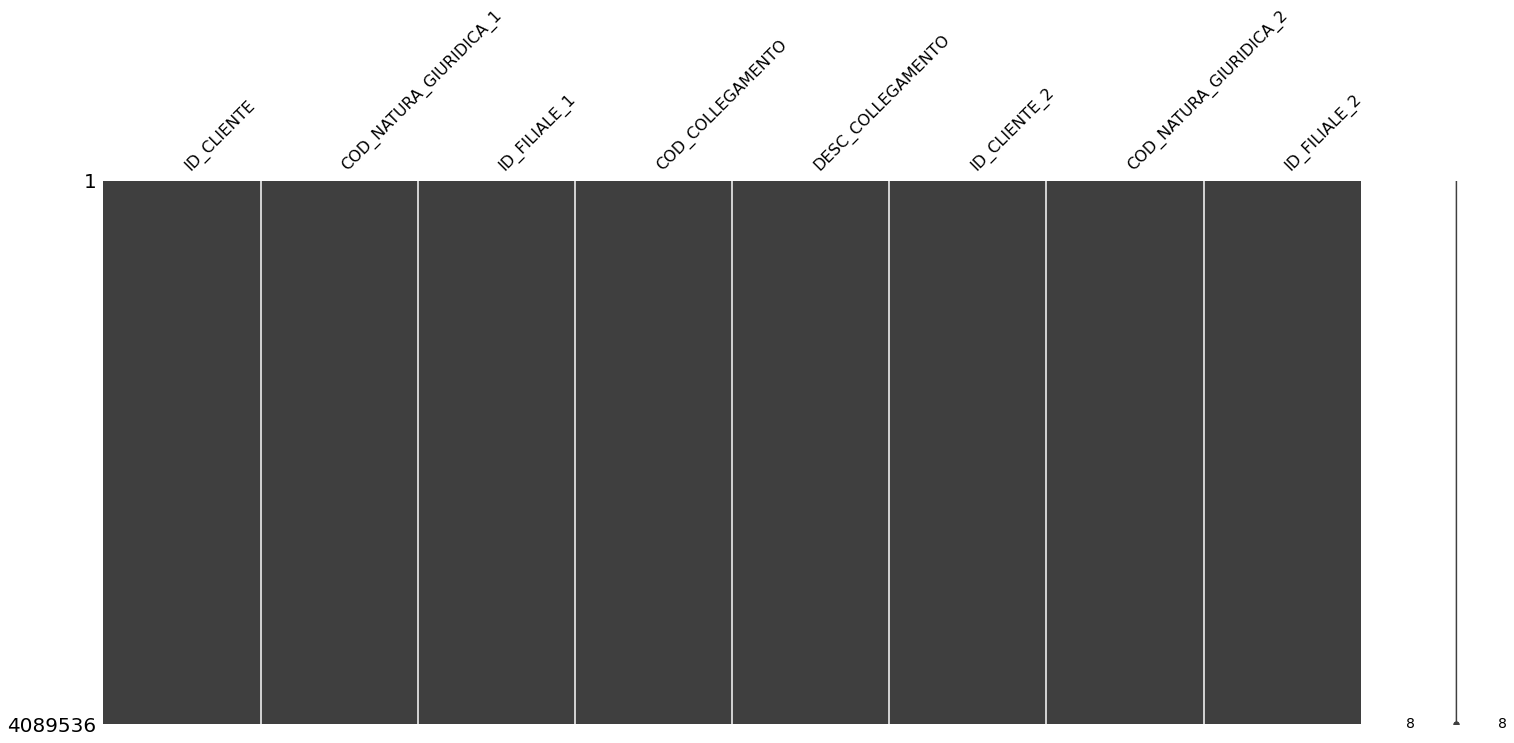

In [44]:
msno.matrix(df2)

In [45]:
df2.head()

ID_CLIENTE COD_NATURA_GIURIDICA_1  ...  COD_NATURA_GIURIDICA_2 ID_FILIALE_2
0     6123972                     DI  ...                      PF        28438
1     6123981                     DI  ...                      PF        28638
2     6123989                     PF  ...                      PF        45955
3     6124027                     PF  ...                      PF        45854
4     6124027                     PF  ...                      PF        45358

[5 rows x 8 columns]

In [46]:
df2.shape

(4089536, 8)

In [47]:
df2['DESC_COLLEGAMENTO'].value_counts()

COINTESTATARIO          2246312
COINTESTAT.REFERENTE    1046037
TIT. DITTA INDIV.        219765
ESERC.POTESTA' X MIN     144792
TITOLARE EFFETTIVO       141265
                         ...   
RETTORE                       1
AGENTE ASSICURATIVO           1
VICE PRES. SOCIETA'           1
PRESENTAT.NUOVO CLIE          1
DETENTORE MAGGIOR.            1
Name: DESC_COLLEGAMENTO, Length: 61, dtype: int64

In [48]:
# assegno un punteggio ad ogni valore evidenziato durante la presentazione

punteggi_collegamenti = {
    'COINTESTATARIO': 0.9,
    'COINTESTAT.REFERENTE': 0.9,
    'TUTORE': 0.9,
    'CONIUNGE': 0.9,
    'HA COME EREDE': 0.9,
    'TIT. DITTA INDIV.': 0.9,
    'TITOLARE EFFETTIVO': 0.9
}

In [49]:
# assegno tutti i punteggi del dizionario sopra al valore indicato, tutto il
# resto viene impostato a 0
df2['PUNTEGGIO_COLLEGAMENTO'] = 0
df2['PUNTEGGIO_COLLEGAMENTO'] = df2['DESC_COLLEGAMENTO'].replace(punteggi_collegamenti)
df2.loc[~df2['DESC_COLLEGAMENTO'].isin(list(punteggi_collegamenti.keys())), 'PUNTEGGIO_COLLEGAMENTO'] = 0

In [50]:
df2['PUNTEGGIO_COLLEGAMENTO'].value_counts()

0.9    3815092
0.0     274444
Name: PUNTEGGIO_COLLEGAMENTO, dtype: int64

In [51]:
# nel primo dataset ci sono molti meno id che nel secondo, questo causerà un 
# numero considerevole di valori nulli
df_questionari[['ID_CLIENTE', 'PUNTEGGIO_CLIENTE']].drop_duplicates().shape, df2['ID_CLIENTE'].nunique()

((107367, 2), 1470869)

In [52]:
df_questionari.shape, df2.shape

((601384, 12), (4089536, 9))

In [53]:
# ottenimento di tutti gli id dei clienti, unisco le colonne dando nomi uniformi
df_clienti_1 = df2[['ID_CLIENTE', 'COD_NATURA_GIURIDICA_1', 'ID_FILIALE_1']].rename(columns={'ID_CLIENTE':'ID_CLIENTE', 'COD_NATURA_GIURIDICA_1':'COD_NATURA_GIURIDICA', 'ID_FILIALE_1':'ID_FILIALE'})
df_clienti_2 = df2[['ID_CLIENTE_2', 'COD_NATURA_GIURIDICA_2', 'ID_FILIALE_2']].rename(columns={'ID_CLIENTE_2':'ID_CLIENTE', 'COD_NATURA_GIURIDICA_2':'COD_NATURA_GIURIDICA', 'ID_FILIALE_2':'ID_FILIALE'})

df_clienti = df_clienti_1.append(df_clienti_2).drop_duplicates()
# vado ad aggiungere tutti i punteggi calcolati in precedenza
df_clienti.merge(df_questionari[['ID_CLIENTE', 'PUNTEGGIO_CLIENTE']].drop_duplicates(), how='left', left_on='ID_CLIENTE', right_on='ID_CLIENTE').to_csv('clienti.csv', index=False)

In [54]:
# tutte le relazioni che uniscono i clienti
df2[['ID_CLIENTE', 'COD_COLLEGAMENTO', 'DESC_COLLEGAMENTO', 'PUNTEGGIO_COLLEGAMENTO', 'ID_CLIENTE_2']].to_csv('relazioni_clienti.csv', index=False)

In [55]:
# tutte le filiali
df2['ID_FILIALE_1'].append(df2['ID_FILIALE_2']).drop_duplicates().to_csv('filiali.csv', index=False)

In [56]:
# filiali del cliente 1
df2[['ID_CLIENTE', 'ID_FILIALE_1']].to_csv('rel_filiale_cliente_1.csv', index=False)

In [57]:
# filiali del cliente 2
df2[['ID_CLIENTE_2', 'ID_FILIALE_2']].to_csv('rel_filiale_cliente_2.csv', index=False)